# Swahili News Classification Problem

[Guyo Dub Jarso ](https://www.linkedin.com/in/guyo-dub-jarso-049a1a127/).


## Overview
Kiswahili is a lingua franca spoken by 100-150 million people across East Africa. It is an official language in the DRC, Kenya, Tanzania, and Uganda; in Tanzania it is a first language for most people and the official language of instruction in all schools, while in other countries it is a common second language. News in Kiswahili is an important part of the media sphere in East Africa.

News contributes to education, technology, and economic growth of a country, and news in local languages plays an important cultural role in many Africa countries. In the modern age, African languages in news and other spheres are at risk of being lost as English becomes the dominant language in online spaces.

## Objective
The objective of this project is to develop a multi-class classification model to classify news content according to six specific categories.

## Application
This result (Model) of this project can be used by Swahili online platforms to automatically group news according to their categories and help readers find the specific news they want to read.


### Contribution
In addition, the model will contribute to a body of work ensuring that Swahili is represented in apps and other online products in future.

### Install and import neccesary libraries

In [26]:
#Import neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#export
import os
import time
import re
from tqdm import tqdm

#libraries for feature engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

##Libraries for machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


##Libraries for model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

#libraries for data preprocessing
from nltk import word_tokenize
from bs4 import BeautifulSoup
from io import StringIO
import re

#libraries for saving the model
import joblib

#Functions
def train_test_model(model, X_train, X_test, y_train, y_test,labels):
    """ Train and test the model using the training and test data sets. Return the predictions, accuracy and metric reports. """
    print('Start training...', end='')
    model.fit(X_train, y_train)
    print('done!')
    print('Start testing...', end='')
    predictions = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    metrics_report = classification_report(y_test, predictions, target_names=labels)
    precision, recall, fscore, train_support = score(y_test, predictions, average='weighted')
    print('done!')
    return predictions, accuracy, metrics_report, (precision, recall, fscore) 


#export
def load_data(file_path):
    """ Load the csv file and return a Dataframe. """
    df = pd.read_csv(file_path, delimiter=',')
    return df

def clean_text(text):
    """ clean the text by removing special characters, punctuations, etc. """
    text = text.lower()
    remove_xx_seq  = re.compile('xx+')
    replace_by_space = re.compile('[/(){}\[\]\|@,;]')
    remove_special_characters = re.compile('[^0-9a-z +]')
    remove_extra_space = re.compile('[^A-Za-z0-9]+')
    remove_numbers = re.compile('[0-9]+')
    text = re.sub(remove_xx_seq, ' ', text)
    text = re.sub(replace_by_space, ' ', text)
    text = re.sub(remove_special_characters, ' ', text)
    text = re.sub(remove_numbers, ' ', text)
    text = re.sub(remove_extra_space, ' ', text)
    return text.strip()


def preprocess_corpus(df, column='text'):
    """ Preprocess the entire corpus including cleaning the text documents and return the updated dataframe. """
    df[column] = df[column].apply(clean_text)
    return df

def encode_labels(labels):
    """ Encode the class labels into a numbers. """
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(labels)
    return label_encoder

# Load the data

In [27]:
#read the data set
df = pd.read_csv('data.csv')
df.head()

,id,content,category
0,SW4670,"Bodi ya Utalii Tanzania (TTB) imesema, itafan...",uchumi
1,SW30826,"PENDO FUNDISHA-MBEYA RAIS Dk. John Magufuri, ...",kitaifa
2,SW29725,Mwandishi Wetu -Singida BENKI ya NMB imetoa ms...,uchumi
3,SW20901,"TIMU ya taifa ya Tanzania, Serengeti Boys jan...",michezo
4,SW12560,Na AGATHA CHARLES – DAR ES SALAAM ALIYEKUWA K...,kitaifa


In [28]:
#drop missing values
df = df[pd.notnull(df['content'])]

In [29]:
#get a concise summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23268 entries, 0 to 23267
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        23268 non-null  object
 1   content   23268 non-null  object
 2   category  23268 non-null  object
dtypes: object(3)
memory usage: 727.1+ KB


In [30]:
#Check columns in the data
df.columns

Index(['id', 'content', 'category'], dtype='object')

In [31]:
# encode the category column and save as category_id
df['category_id'] = df['category'].factorize()[0]
#drop duplicates
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
#convert to a dictionary
category_to_id = dict(category_id_df.values)
#Create a dictionary of category and category_id
id_to_category = dict(category_id_df[['category_id', 'category']].values)

# Classes

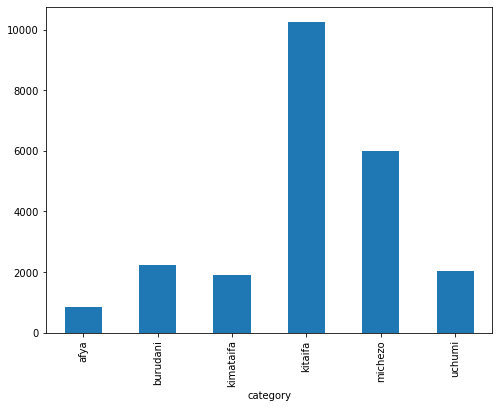

In [32]:
#Plot the classes
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category').content.count().plot.bar(ylim=0)
plt.show()

It is clear from the bar chart above that the class is imbalanced

# Let See the few lines of the data

In [33]:
#Get the 5 rows of the data set
df.head()

,id,content,category,category_id
0,SW4670,"Bodi ya Utalii Tanzania (TTB) imesema, itafan...",uchumi,0
1,SW30826,"PENDO FUNDISHA-MBEYA RAIS Dk. John Magufuri, ...",kitaifa,1
2,SW29725,Mwandishi Wetu -Singida BENKI ya NMB imetoa ms...,uchumi,0
3,SW20901,"TIMU ya taifa ya Tanzania, Serengeti Boys jan...",michezo,2
4,SW12560,Na AGATHA CHARLES – DAR ES SALAAM ALIYEKUWA K...,kitaifa,1


# A few things to notice here
We have some of the noise in the data so we have to remove all that and also lets convert text into lower case.

# Preprocessing

In [34]:
df['content'] = df['content'].apply(lambda x: x.lower()) #lower casing
df['content'] = df['content'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # removing special chars

# Let's look at the data again

In [35]:
df.head(-5)

,id,content,category,category_id
0,SW4670,bodi ya utalii tanzania ttb imesema itafanya ...,uchumi,0
1,SW30826,pendo fundishambeya rais dk john magufuri ame...,kitaifa,1
2,SW29725,mwandishi wetu singida benki ya nmb imetoa msa...,uchumi,0
3,SW20901,timu ya taifa ya tanzania serengeti boys jana...,michezo,2
4,SW12560,na agatha charles dar es salaam aliyekuwa ka...,kitaifa,1
...,...,...,...,...
23258,SW6098,na ramadhan libenangamorogoro \r\nwafugaji wil...,kitaifa,1
23259,SW24061,mwandishi wetudar es salaam zaidi ya wafanyabi...,uchumi,0
23260,SW12537,na said ameir maelezo kuwapatia wananchi dawa...,afya,5
23261,SW5272,mwili wa binadamu na viumbe wengine kama vile...,afya,5


Now the data looks better

# This looks better.

Lets pre-process the data so that we can use it to train the model

Converting news into numerical data(TFI-DF)

train test split

In [36]:
# Create tfidf features from the text
ngram_range   = (1, 1)
max_features  = None
vectorizer = TfidfVectorizer(input='content', ngram_range=ngram_range, min_df=3, max_df=0.9, max_features=max_features)

# X, vectorizer = compute_tfidf(df['content'], stop_words, ngram_range, max_features)
X = vectorizer.fit_transform(df['content'].values)

# Encode the labels
labels = df.category.unique()
label_encoder = encode_labels(labels)
y = label_encoder.transform(df.category)

# Split the dataset

In [37]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print('Training set Shape: {}  | Test set Shape: {}'.format(X_train.shape, X_test.shape))

Training set Shape: (18614, 66647)  | Test set Shape: (4654, 66647)


## Model Building

### Comparing different models in cross-validation

I am  comparing 3 models; 


- Naive Bayes (NB)

- Linear SVM

- Random Forest


Ther are so many ML models out there for multi-lass classsification but I have decided to use this three. 

However, please note that, I am  doing Multinomial Classifier because it is often the baseline classifier for a text classification. Support Vector machine because it does well in a sparse data set and will also try Random Forest Classifier because it is good in this kind of classification.



## Naive Bayes Classifier

Number of documents = 18614  |  Number of features = 66647
Start training...done!
Start testing...done!
Total time: 0.20s
accuracy: 0.7516115169746455
              precision    recall  f1-score   support

      uchumi       0.00      0.00      0.00       172
     kitaifa       0.88      0.58      0.70       446
     michezo       1.00      0.11      0.19       381
   kimataifa       0.66      0.98      0.79      2048
    burudani       0.93      0.88      0.90      1201
        afya       1.00      0.33      0.50       406

    accuracy                           0.75      4654
   macro avg       0.74      0.48      0.51      4654
weighted avg       0.78      0.75      0.71      4654



C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\

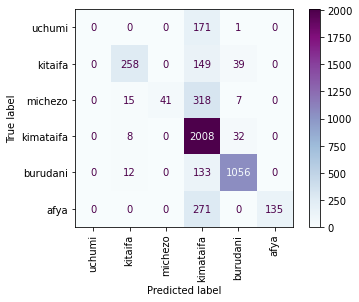

In [43]:
nb_model = MultinomialNB()
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, nb_prf = train_test_model(nb_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(nb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")
# plt.show()

## SVM

Number of documents = 18614  |  Number of features = 66647
Start training...done!
Start testing...done!
Total time: 1.75s
accuracy: 0.86377309840997
              precision    recall  f1-score   support

      uchumi       0.46      0.60      0.52       172
     kitaifa       0.82      0.92      0.87       446
     michezo       0.84      0.89      0.87       381
   kimataifa       0.90      0.84      0.87      2048
    burudani       0.95      0.93      0.94      1201
        afya       0.74      0.80      0.77       406

    accuracy                           0.86      4654
   macro avg       0.79      0.83      0.81      4654
weighted avg       0.87      0.86      0.87      4654



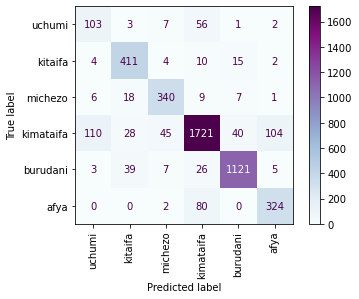

In [39]:
svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, svm_prf = train_test_model(svm, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(svm, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

## Random Forest

Number of documents = 18614  |  Number of features = 66647
Start training...done!
Start testing...done!
Total time: 28.77s
accuracy: 0.8070477009024495
              precision    recall  f1-score   support

      uchumi       0.14      0.02      0.04       172
     kitaifa       0.86      0.80      0.83       446
     michezo       0.89      0.45      0.60       381
   kimataifa       0.73      0.96      0.83      2048
    burudani       0.95      0.92      0.93      1201
        afya       0.99      0.38      0.55       406

    accuracy                           0.81      4654
   macro avg       0.76      0.59      0.63      4654
weighted avg       0.81      0.81      0.78      4654



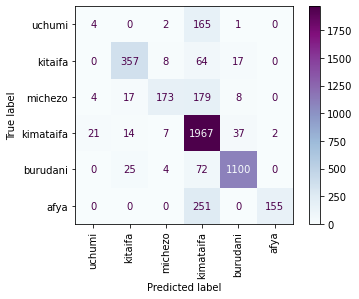

In [40]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, rf_prf = train_test_model(rf_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(rf_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

## Cross Validation of the model

To cope up with imbalanced datasets,  cross validation will be performed.

In [85]:
#List of all the models
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
]
#Choose the number of cross validations
CV = 5
#dataframe
cv_df = pd.DataFrame(index=range(CV * len(models)))
#iterate over the models, fit the models and store their accuracies in a list entries
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

#convert the list to datframe
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

### Plot model accuracies

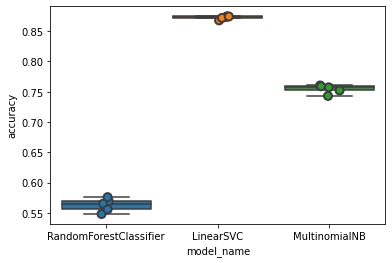

In [86]:
#plot the model accuracies
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
#group the mean accuracy of the model by the names of the model
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.870380
MultinomialNB             0.839694
RandomForestClassifier    0.659360
Name: accuracy, dtype: float64

The cross validation results show that the mean accuracy of SVM is 87%, thus still the front runner by followed by naive bayes at 85% accuracy and Random Forest ranking at position 3 with 65% accuracy

We can see also from the confusion matrix and classification report that SVM and Naive Bayes Classifiers are doing well in classifying this data

In [42]:
nb_model

MultinomialNB()

In [44]:
y_pred = nb_model.predict( X_test)
y_pred

array([3, 4, 3, ..., 3, 3, 3])

# Let us look again at the confusion matrix for Naive Bayes Classifier

In [49]:
model = nb_model

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Classification report

In [50]:
#Classification report of LinearSVC
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['category'].unique()))

              precision    recall  f1-score   support

      uchumi       0.00      0.00      0.00       300
     kitaifa       0.89      0.47      0.61       721
     michezo       1.00      0.08      0.15       600
   kimataifa       0.65      0.98      0.78      3404
    burudani       0.92      0.88      0.90      1965
        afya       1.00      0.30      0.46       689

    accuracy                           0.74      7679
   macro avg       0.74      0.45      0.48      7679
weighted avg       0.77      0.74      0.69      7679



C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


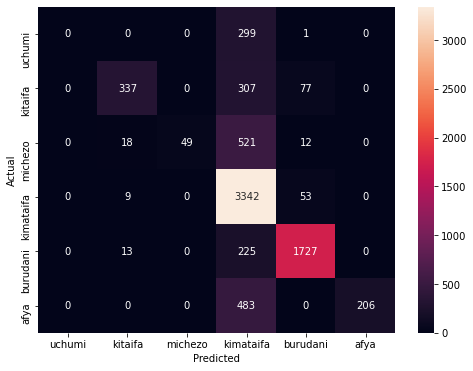

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Test the predictions

In [52]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'content']])
      print('')

'michezo' predicted as 'kitaifa' : 18 examples.


,category,content
22034,kimataifa,badi mchomolo na mitandao mtanzania linakulet...
3818,kimataifa,na christopher msekena hakuna msanii duniani a...
791,kimataifa,new york marekani staa wa muziki wa\r\nrnb nc...
7433,kimataifa,new york marekani nyota wa muziki wa hip hop ...
6648,kimataifa,new york marekani rapa\r\noffset na mke wake ...
7506,kimataifa,cape\r\ntown afrika kusini mashabiki wa muziki...
8143,kimataifa,new york marekani mtoto wa staa wa muziki nchi...
11906,kimataifa,new york marekani rapa kanye west amesema kil...
12727,kimataifa,new york marekani mwanamitindo kutoka familia...
17876,kimataifa,paris ufaransa staa wa muziki wa hip hop nchi...



'kimataifa' predicted as 'kitaifa' : 9 examples.


,category,content
19753,kitaifa,msanii ommy dimpoz amewazodoa waliomzushia ki...
13506,kitaifa,na christopher msekenadar es salaam mwanamiti...
1984,kitaifa,wasanii wa muziki wa bongo fleva vanessa mdee...
13580,kitaifa,\r\n\r\n \r\n\tna christopher msekena\r\n \r\n...
5289,kitaifa,the tanzania peoples defence forces tpdf has ...
8692,kitaifa,na glory mlay msanii wa bongo fleva marianne m...
8369,kitaifa,na bethsheba wambura dar es salaam msanii mko...
14585,kitaifa,na jessca nangawe staa wa mitindo nchini hami...
20910,kitaifa,msanii wa muziki nchini richard mavoko amekan...



'burudani' predicted as 'kitaifa' : 13 examples.


,category,content
11666,michezo,diamond alitangazwa mwanamuziki bora wa kiume...
9490,michezo,hivi karibu mwekezaji na mwenyekiti wa bodi ya...
18743,michezo,msanii vanessa mdee vee money amesaini mkatab...
7889,michezo,mwaka jana diamond alipata tuzo 10 na kwa mwa...
11362,michezo,rais wa wcb na msanii naseeb abdul maarufu ka...
10970,michezo,kwa mujibu wa mitandao kutoka nigeria vanessa...
974,michezo,mrembo na mfanyabiashara wa uganda zari hassa...
10725,michezo,msanii wa muziki wa kizazi kipya nchini omary...
5076,michezo,nuh ambaye mara zote amekuwa akiimba nyimbo z...
13582,michezo,nyota wa muziki nchini jana walijitokeza kwen...



'uchumi' predicted as 'kimataifa' : 299 examples.


,category,content
7027,afya,na salum vuaizanzibar waziri wa kazi uwezesha...
3173,afya,aveline kitomary dar es salaam maabara ya mkem...
12076,afya,christian bwaya hivi karibuni nilishuhudia\r\n...
7222,afya,nyemo malecelabukoba wanakijiji wenye hasira k...
13367,afya,mwandishi wetu dar es salaam waimba kwaya wa k...
...,...,...
16421,afya,na tunu nassor dar es salaam jamii imeombwa ku...
10626,afya,na veronica romwald aliyekuwa kenya kwa ka...
2071,afya,na veronica romwald dar es salaam serikali i...
15272,afya,janeth mushibabati chama cha wafugaji tanzania...



'kitaifa' predicted as 'kimataifa' : 307 examples.


,category,content
1730,burudani,na esther georgedar es salaam aliyekuwa meneja...
14952,burudani,mwanamuziki wa taarab isha mashauzi ameweka w...
21636,burudani,new york marekani baada ya nyota wa zamani wa ...
16675,burudani,\r\n\r\n \r\n\tna joseph shaluwa\r\n \r\n\tmas...
3882,burudani,\r\n\tna kyalaa seheye\r\n \r\n\r\n \r\n\tmwan...
...,...,...
11307,burudani,na mwali ibrahim safari ya mwisho duniani ya m...
17569,burudani,na suzana makorongo rct unaweza kusema kwamba ...
22660,burudani,na christopher msekena mkali wa vichekesho nch...
9337,burudani,jeremia ernest mbunifu maarufu wa mavazi nchin...



'michezo' predicted as 'kimataifa' : 521 examples.


,category,content
31,kimataifa,\r\n\tharare zimbabwe\r\n \r\n\r\n \r\n\tfamil...
8383,kimataifa,washingtondcmarekani wizara ya ulinzi imese...
19151,kimataifa,moscow urusi rais vladimir putin wa urusi ame...
9162,kimataifa,kampala uganda tume ya mawasiliano uganda ucc...
13888,kimataifa,nairobi kenya mbunge wa ruaraka tom j kajwang...
...,...,...
2553,kimataifa,nairobi kenya rais uhuru kenyatta ataapishwa ...
20207,kimataifa,nairobi kenya kenya inaongoza miongoni mwa ma...
6151,kimataifa,nairobi kenya kinara wa muungano wa upinzani ...
1554,kimataifa,kigali\r\nrwanda kampuni ya mara nchini rwanda...



'burudani' predicted as 'kimataifa' : 225 examples.


,category,content
14155,michezo,na fredy azzahdodoma serikali imetoa sababu ti...
4920,michezo,baada ya kuachiwa huru mbasha alitoka nje ya ...
9331,michezo,zawadi hizo zitatolewa katika promosheni ya k...
9268,michezo,mkuu wa chuo cha kumbukumbu ya mwalimu nyerer...
21233,michezo,muigizaji wa bongo movie wema sepetu amesema ...
...,...,...
5419,michezo,msichana huoy amesema haamini kama amebeba ta...
21487,michezo,na mwandishi wetu kampuni ya sokabet imeingia...
6704,michezo,akizungumza na gazeti hili jana meneja wa cds...
5307,michezo,hatimaye aliyekuwa rais wa shirikisho la soka...



'afya' predicted as 'kimataifa' : 483 examples.


,category,content
11140,uchumi,alisema serikali imedhamiria kuwa na uchumi w...
14909,uchumi,rai hiyo ilitolewa jana na mkuu wa mkoa wa mo...
8465,uchumi,wiki hii julai 1 benki ya dunia iliingiza tanz...
21690,uchumi,aliongeza kuwa mbali ya kutekeleza dhamira hi...
20148,uchumi,wafanyabiashara 14 kutoka mikoa ya arusha tab...
...,...,...
10201,uchumi,kauli hiyo ilitolewa na waziri wa maliasili n...
20326,uchumi,wakulima 17 wa mashamba ya miwa wilayani kilo...
18152,uchumi,imeelezwa kwamba serikali itakapokamilisha tr...
12376,uchumi,waziri mkuu kassim majaliwa amesema mkoa wa t...



'kitaifa' predicted as 'burudani' : 77 examples.


,category,content
2462,burudani,theresia gasper dar es salaam kocha mkuu wa y...
18616,burudani,na glory mlay mwimbaji nyota wa singeli nchini...
16202,burudani,kwa kipindi kirefu sasa mchezo wa riadha hapa...
130,burudani,paris ufaransa bingwa namba mbili kwa ubora w...
7311,burudani,meneja wa nyota wa bongo fleva sallam sk amese...
...,...,...
14643,burudani,new york marekani mkali wa muziki wa hip hop k...
12375,burudani,\r\n\tlagos nigeria\r\n \r\n\r\n \r\n\twiki ch...
20473,burudani,new york marekani nyota wa muziki kutoka nchin...
3811,burudani,na koku david msanii wa muziki wa kizazi kipya...



'michezo' predicted as 'burudani' : 12 examples.


,category,content
9093,kimataifa,new york marekani staa wa muziki na filamu nch...
19800,kimataifa,mabingwa wa ligi kuu nchini england chelsea wa...
11809,kimataifa,kiev ukraine mchezaji bora duniani cristiano ...
12590,kimataifa,caracas\r\nvenezuela rais wa venezuela nicolas...
9746,kimataifa,cairo misri nahodha wa timu ya taifa ya zimbab...
12144,kimataifa,monrovia liberia nyota wa zamani wa mpira wa ...
2868,kimataifa,los angeles marekani staa wa muziki na\r\nfil...
19481,kimataifa,na lulu ringo mzani umebalance michuano ya ko...
19252,kimataifa,new york marekani mkali wa muziki wa hip hop j...
7103,kimataifa,saint petersburg urusi leo kwenye uwanja wa s...



'kimataifa' predicted as 'burudani' : 53 examples.


,category,content
4890,kitaifa,anna potinus dar es salaam mfanyabiashara ma...
9308,kitaifa,na jennifer ullembodar es salaam mshambuliaji...
18608,kitaifa,muhadjiri hakizimana ndiye mchezaji bora wa m...
5147,kitaifa,kocha mkuu wa simba patrick aussems amesema b...
9224,kitaifa,timu ya soka ya taifa taifa stars imewasili s...
21544,kitaifa,na mohamed kassara dar es salaam klabu ya sim...
20741,kitaifa,kikosi cha timu ya soka ya jkt tanzania kimew...
11572,kitaifa,ac milan wamesema hawakubaliani na kampeni ya...
2302,kitaifa,na jennifer ullembodar es salaam mashabiki wa...
5039,kitaifa,wachezaji wa mbao fc metacha mnata na vincent...


### Show 10 Working examples

In [54]:
#Store 10 news items in a list
texts = ["Habari ya kutatanisha kinasema ya kwamba kuna mtu ameaga dunia.",
         "Manchester United walishinda mchezo huo jana na kutinga nusu fainali.",
         "Timu ya Harambe Star yacheza na timu ya Tanzania",
         "Mwanafunzi aanguka kwenye darasa na akufa.",
         "Rais wa Marekani atembelea nchi ya Kenya na Tanzania",
         "Uchanguzi yafanyika nchi Uganda",
         "Trump hupoteza uchaguzi wake kwa Joe Biden.",
         'Rais wa Tanzania Pombe Magufuli afariki dunia.'
         ]
#transform the test data
text_features = vectorizer.transform(texts)
#Predict the transformed test data
predictions = model.predict(text_features)
#iterate over the test data and their predictions and print them with their predicted class
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"Habari ya kutatanisha kinasema ya kwamba kuna mtu ameaga dunia."
  - Predicted as: 'kimataifa'

"Manchester United walishinda mchezo huo jana na kutinga nusu fainali."
  - Predicted as: 'burudani'

"Timu ya Harambe Star yacheza na timu ya Tanzania"
  - Predicted as: 'burudani'

"Mwanafunzi aanguka kwenye darasa na akufa."
  - Predicted as: 'kimataifa'

"Rais wa Marekani atembelea nchi ya Kenya na Tanzania"
  - Predicted as: 'kimataifa'

"Uchanguzi yafanyika nchi Uganda"
  - Predicted as: 'kimataifa'

"Trump hupoteza uchaguzi wake kwa Joe Biden."
  - Predicted as: 'michezo'

"Rais wa Tanzania Pombe Magufuli afariki dunia."
  - Predicted as: 'kimataifa'



# Save the best model

In [ ]:
model =model

In [55]:
#dumb the LinearSVC model in a pickle file
joblib.dump(model, 'nb1_Swahili_model.pkl')

['nb1_Swahili_model.pkl']

In [56]:
#read  the model
nb1_Swahili_model = open('nb1_Swahili_model.pkl','rb')

In [57]:
#load the model
model = joblib.load(nb1_Swahili_model)

In [58]:
#Check model parameters
model

MultinomialNB()

From the confusion matrix, Multinomial Naive Bayes seem to be a better classifier. We shall use it to classify our news articles. This model will be deployed in Python Flask framework, dockerize and deployed on google cloud platform with Kuberenetes to gurantee scalability.

# Save the Vectorizer

In [59]:
import pickle

In [60]:
# now pickle
pickle.dump(vectorizer, open("vector.pickel", "wb"))

In [61]:
vectorizer = pickle.load(open("vector.pickel", "rb"))

### Note

In this notebook,  I have not removed stopwords from the corpus, this is because there is no complete Swahili stopwords currently available, stopwords have not been removed.


Removing the stopwords may potentially improve the accuracy of these models.